# Model Pruning & Benchmarking for Cats vs Non-Cats CNN

This notebook loads your trained `CustomCNN` from `checkpoints/final_best.pt`,
applies unstructured pruning at various sparsity levels, and reports metrics on
accuracy, size, sparsity, FLOPs, and throughput.

**Assumed structure**:
- `checkpoints/final_best.pt`
- `cats-v-non-cats/validation/`
- `cats-v-non-cats/test/`

Adjust paths if needed.

In [ ]:
# %pip install cmake

# %pip install onnx onnxruntime 
%pip install onnx-simplifier

^C
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      <string>:26: DeprecationWarning: Use shutil.which instead of find_executable
      fatal: not a git repository (or any of the parent directories): .git
      fatal: not a git repository (or any of the parent directories): .git
      Traceback (most recent call last):
        File "c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
        File "c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_v

  Using cached onnx-simplifier-0.4.36.tar.gz (21.0 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/6a/95/9d93b8cfdd9f57abe7000cd6b9e56e2c518ce0e6bf6b312b1cf37b4e68a8/onnx-simplifier-0.4.36.tar.gz (from https://pypi.org/simple/onnx-simplifier/) (requires-python:>=3.7): Requested onnxsim from https://files.pythonhosted.org/packages/6a/95/9d93b8cfdd9f57abe7000cd6b9e56e2c518ce0e6bf6b312b1cf37b4e68a8/onnx-simplifier-0.4.36.tar.gz has inconsistent name: expected 'onnx-simplifier', but metadata has 'onnxsim'
  Using cached onnx-simplifier-0.4.35.tar.gz (20.1

In [7]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

CHECKPOINT_PATH = "checkpoints/final_best.pt"
IMG_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP = torch.cuda.is_available()

VALIDATION_DIR = "cats-v-non-cats/validation/"
TESTING_DIR = "cats-v-non-cats/test/"

PRUNING_AMOUNTS = [0.2, 0.4, 0.6, 0.8]

print(f"Using device: {DEVICE}")
print(f"Mixed precision: {AMP}")

Using device: cuda
Mixed precision: True


In [8]:
import copy
import torch.onnx as torch_onnx
import onnx
import os

def export_model_to_onnx(model, filename="cats_cnn.onnx"):
    """
    Export the given PyTorch model to an ONNX file.
    Assumes input shape (N, 3, IMG_SIZE, IMG_SIZE).
    """
    model_cpu = copy.deepcopy(model).to("cpu")
    model_cpu.eval()

    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

    os.makedirs("onnx_exports", exist_ok=True)
    out_path = os.path.join("onnx_exports", filename)

    torch_onnx.export(
        model_cpu,
        dummy_input,
        out_path,
        export_params=True,
        opset_version=17,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["logits"],
        dynamic_axes={"input": {0: "batch_size"},
                      "logits": {0: "batch_size"}},
    )

    size_mb = os.path.getsize(out_path) / 1024**2
    print(f"✅ Exported ONNX model to {out_path} ({size_mb:.2f} MB)")

    # quick sanity check: can we load it?
    onnx_model = onnx.load(out_path)
    onnx.checker.check_model(onnx_model)
    print("✅ ONNX model passed checker")

    return out_path, size_mb


## Model Definition
Must match your training notebook so the checkpoint loads correctly.

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, reg_strength: float, dropout_conv: float, dropout_dense: float,
                 dense_units: int, filters_multiplier: float):
        super().__init__()
        f1 = max(8, int(32 * filters_multiplier))
        f2 = max(16, int(64 * filters_multiplier))
        f3 = max(32, int(128 * filters_multiplier))

        self.block1 = nn.Sequential(
            nn.Conv2d(3, f1, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f1),
            nn.Conv2d(f1, f1, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, f2, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f2),
            nn.Conv2d(f2, f2, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(f2, f3, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f3),
            nn.Conv2d(f3, f3, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(f3, dense_units), nn.ReLU(inplace=True),
            nn.BatchNorm1d(dense_units),
            nn.Dropout(dropout_dense),
            nn.Linear(dense_units, 1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        return self.head(x)

## Data Loading
Validation + test loaders for evaluation only.

In [10]:
def build_eval_loaders(batch_size=128):
    val_tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

    val_ds = datasets.ImageFolder(VALIDATION_DIR, transform=val_tfms)
    test_ds = datasets.ImageFolder(TESTING_DIR, transform=val_tfms)

    kwargs = dict(num_workers=4, pin_memory=True) if torch.cuda.is_available() else {}
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, **kwargs)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

    return val_loader, test_loader

## Evaluation Utilities

In [11]:
@torch.no_grad()
def evaluate_model(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    total_time = 0.0
    n_batches = 0

    criterion = nn.BCEWithLogitsLoss()
    loss_sum = 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        yf = y.float().to(device, non_blocking=True)

        if device.type == 'cuda':
            torch.cuda.synchronize()
        start = time.time()

        with torch.cuda.amp.autocast(enabled=AMP and device.type=='cuda'):
            logits = model(x).squeeze(1)
            loss = criterion(logits, yf)

        if device.type == 'cuda':
            torch.cuda.synchronize()
        total_time += (time.time() - start)
        n_batches += 1

        loss_sum += float(loss.item()) * x.size(0)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs.tolist())
        all_labels.extend(y.cpu().numpy().tolist())

    y_true = np.array(all_labels)
    y_pred = (np.array(all_probs) >= 0.5).astype(int)

    metrics = {
        'accuracy': float((y_pred == y_true).mean()),
        'loss': loss_sum / len(all_labels),
        'auc': roc_auc_score(y_true, all_probs) if len(set(y_true)) > 1 else 0.0,
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'avg_inference_time': total_time / max(n_batches, 1),
        'throughput': len(all_labels) / total_time if total_time > 0 else 0.0
    }
    return metrics

def measure_model_size(model):
    param_size = 0
    param_count = 0
    buffer_size = 0

    for param in model.parameters():
        param_count += param.nelement()
        param_size += param.nelement() * param.element_size()

    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_mb = (param_size + buffer_size) / 1024**2

    return {
        'size_mb': size_mb,
        'param_count': param_count,
        'param_size_mb': param_size / 1024**2,
        'buffer_size_mb': buffer_size / 1024**2
    }

def count_zero_parameters(model):
    zeros = 0
    total = 0
    for param in model.parameters():
        if param is not None:
            zeros += torch.sum(param == 0).item()
            total += param.nelement()
    sparsity = 100.0 * zeros / total if total > 0 else 0.0
    return zeros, total, sparsity

def estimate_flops(model, input_size=(1, 3, 128, 128)):
    device = next(model.parameters()).device
    dummy_input = torch.randn(input_size).to(device)
    flops = 0

    def conv_hook(module, input, output):
        nonlocal flops
        batch_size = input[0].size(0)
        out_c = output.size(1)
        out_h = output.size(2)
        out_w = output.size(3)
        k_h, k_w = module.kernel_size
        in_c = module.in_channels
        flops += batch_size * out_c * out_h * out_w * in_c * k_h * k_w

    def linear_hook(module, input, output):
        nonlocal flops
        batch_size = input[0].size(0)
        flops += batch_size * module.in_features * module.out_features

    hooks = []
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            hooks.append(m.register_forward_hook(conv_hook))
        elif isinstance(m, nn.Linear):
            hooks.append(m.register_forward_hook(linear_hook))

    with torch.no_grad():
        model(dummy_input)

    for h in hooks:
        h.remove()

    return flops / 1e9  # GFLOPs

## Pruning Functions
Unstructured and structured pruning helpers. (Experiments below use unstructured.)

In [12]:
def apply_unstructured_pruning(model, amount=0.5):
    pruned_model = copy.deepcopy(model)
    for _, module in pruned_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    return pruned_model

def apply_structured_pruning(model, amount=0.5):
    pruned_model = copy.deepcopy(model)
    for _, module in pruned_model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')
        elif isinstance(module, nn.Linear):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')
    return pruned_model

def fine_tune_pruned_model(model, train_loader, val_loader, epochs=5, lr=1e-4):
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=AMP)

    best_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.float().to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=AMP):
                logits = model(x).squeeze(1)
                loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        metrics = evaluate_model(model, val_loader, DEVICE)
        if metrics['accuracy'] > best_acc:
            best_acc = metrics['accuracy']
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(f"Epoch {epoch+1}/{epochs} - Val Acc: {metrics['accuracy']:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model

## Load Trained Model

In [13]:
print("="*70)
print("LOADING TRAINED MODEL")
print("="*70)

ckpt = torch.load(CHECKPOINT_PATH, map_location="cpu")
config = ckpt["config"]
state = ckpt["state_dict"]

print("Model configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

original_model = CustomCNN(
    config["reg_strength"],
    config["dropout_conv"],
    config["dropout_dense"],
    int(config["dense_units"]),
    float(config["filters_multiplier"]),
).to(DEVICE)

original_model.load_state_dict(state, strict=True)
original_model.eval()
print("\n✅ Model loaded successfully!")

LOADING TRAINED MODEL
Model configuration:
  learning_rate: 0.00019329441561008272
  reg_strength: 2.1392715033008293e-06
  dropout_conv: 0.3991746766866793
  dropout_dense: 0.4342883979481444
  dense_units: 1024
  filters_multiplier: 1.897507625889965
  batch_size: 64
  beta_1: 0.8828029914578701
  beta_2: 0.9358066391956668

✅ Model loaded successfully!


In [14]:
# Export baseline model to ONNX
baseline_onnx_path, baseline_onnx_size = export_model_to_onnx(
    original_model, filename="baseline_cats_cnn.onnx"
)
print(f"Baseline ONNX size: {baseline_onnx_size:.2f} MB")


✅ Exported ONNX model to onnx_exports\baseline_cats_cnn.onnx (4.88 MB)
✅ ONNX model passed checker
Baseline ONNX size: 4.88 MB


## Baseline Evaluation

In [15]:
print("="*70)
print("BASELINE MODEL EVALUATION")
print("="*70)

val_loader, test_loader = build_eval_loaders(batch_size=128)

print("Evaluating baseline model on test set...")
baseline_metrics = evaluate_model(original_model, test_loader, DEVICE)
baseline_size = measure_model_size(original_model)
baseline_flops = estimate_flops(original_model)
_, _, baseline_sparsity = count_zero_parameters(original_model)

print("\n📊 Baseline Performance:")
for k in ["accuracy", "auc", "f1", "precision", "recall", "loss"]:
    print(f"  {k.capitalize():<10}: {baseline_metrics[k]:.4f}")

print("\n💾 Baseline Model Size:")
print(f"  Total Size: {baseline_size['size_mb']:.2f} MB")
print(f"  Parameters: {baseline_size['param_count']:,}")
print(f"  Sparsity:   {baseline_sparsity:.2f}%")

print("\n⚡ Baseline Efficiency:")
print(f"  Inference Time: {baseline_metrics['avg_inference_time']*1000:.2f} ms/batch")
print(f"  Throughput:     {baseline_metrics['throughput']:.1f} samples/sec")
print(f"  FLOPs:          {baseline_flops:.2f} GFLOPs")

BASELINE MODEL EVALUATION
Evaluating baseline model on test set...


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



📊 Baseline Performance:
  Accuracy  : 0.9691
  Auc       : 0.9953
  F1        : 0.9695
  Precision : 0.9580
  Recall    : 0.9813
  Loss      : 0.0898

💾 Baseline Model Size:
  Total Size: 4.88 MB
  Parameters: 1,275,340
  Sparsity:   0.00%

⚡ Baseline Efficiency:
  Inference Time: 141.91 ms/batch
  Throughput:     836.2 samples/sec
  FLOPs:          2.17 GFLOPs


## Pruning Experiments
Unstructured pruning at multiple sparsity levels; results recorded in `results`.

In [16]:
print("="*70)
print("PRUNING EXPERIMENTS")
print("="*70)

results = {
    'baseline': {
        'metrics': baseline_metrics,
        'size': baseline_size,
        'flops': baseline_flops,
        'sparsity': baseline_sparsity
    }
}

for prune_amount in PRUNING_AMOUNTS:
    print("\n" + "="*70)
    print(f"UNSTRUCTURED PRUNING: {prune_amount*100:.0f}% sparsity")
    print("="*70)

    pruned_model = apply_unstructured_pruning(original_model, amount=prune_amount)
    pruned_model.eval()

    print("Evaluating pruned model (before fine-tuning)...")
    metrics = evaluate_model(pruned_model, test_loader, DEVICE)
    size = measure_model_size(pruned_model)
    flops = estimate_flops(pruned_model)
    _, _, sparsity = count_zero_parameters(pruned_model)

    print(f"  Accuracy:  {metrics['accuracy']:.4f} (Δ {metrics['accuracy']-baseline_metrics['accuracy']:+.4f})")
    print(f"  AUC:       {metrics['auc']:.4f} (Δ {metrics['auc']-baseline_metrics['auc']:+.4f})")
    print(f"  F1:        {metrics['f1']:.4f}")
    print(f"  Sparsity:  {sparsity:.2f}%")
    print(f"  Size (MB): {size['size_mb']:.2f} (Δ {(1 - size['size_mb']/baseline_size['size_mb'])*100:.1f}% reduction)")
    print(f"  FLOPs:     {flops:.2f} GFLOPs")

    results[f'unstructured_{prune_amount}'] = {
        'metrics': metrics,
        'size': size,
        'flops': flops,
        'sparsity': sparsity
    }

PRUNING EXPERIMENTS

UNSTRUCTURED PRUNING: 20% sparsity
Evaluating pruned model (before fine-tuning)...
  Accuracy:  0.9579 (Δ -0.0112)
  AUC:       0.9917 (Δ -0.0036)
  F1:        0.9586
  Sparsity:  19.93%
  Size (MB): 4.88 (Δ 0.0% reduction)
  FLOPs:     2.17 GFLOPs

UNSTRUCTURED PRUNING: 40% sparsity
Evaluating pruned model (before fine-tuning)...
  Accuracy:  0.8652 (Δ -0.1039)
  AUC:       0.9441 (Δ -0.0512)
  F1:        0.8571
  Sparsity:  39.85%
  Size (MB): 4.88 (Δ 0.0% reduction)
  FLOPs:     2.17 GFLOPs

UNSTRUCTURED PRUNING: 60% sparsity
Evaluating pruned model (before fine-tuning)...
  Accuracy:  0.6910 (Δ -0.2781)
  AUC:       0.8640 (Δ -0.1313)
  F1:        0.5758
  Sparsity:  59.78%
  Size (MB): 4.88 (Δ 0.0% reduction)
  FLOPs:     2.17 GFLOPs

UNSTRUCTURED PRUNING: 80% sparsity
Evaluating pruned model (before fine-tuning)...
  Accuracy:  0.5346 (Δ -0.4345)
  AUC:       0.5188 (Δ -0.4765)
  F1:        0.1919
  Sparsity:  79.70%
  Size (MB): 4.88 (Δ 0.0% reduction)
  FLO

## Visualization

Generating visualizations...
✅ Saved visualization to 'pruning_analysis.png'


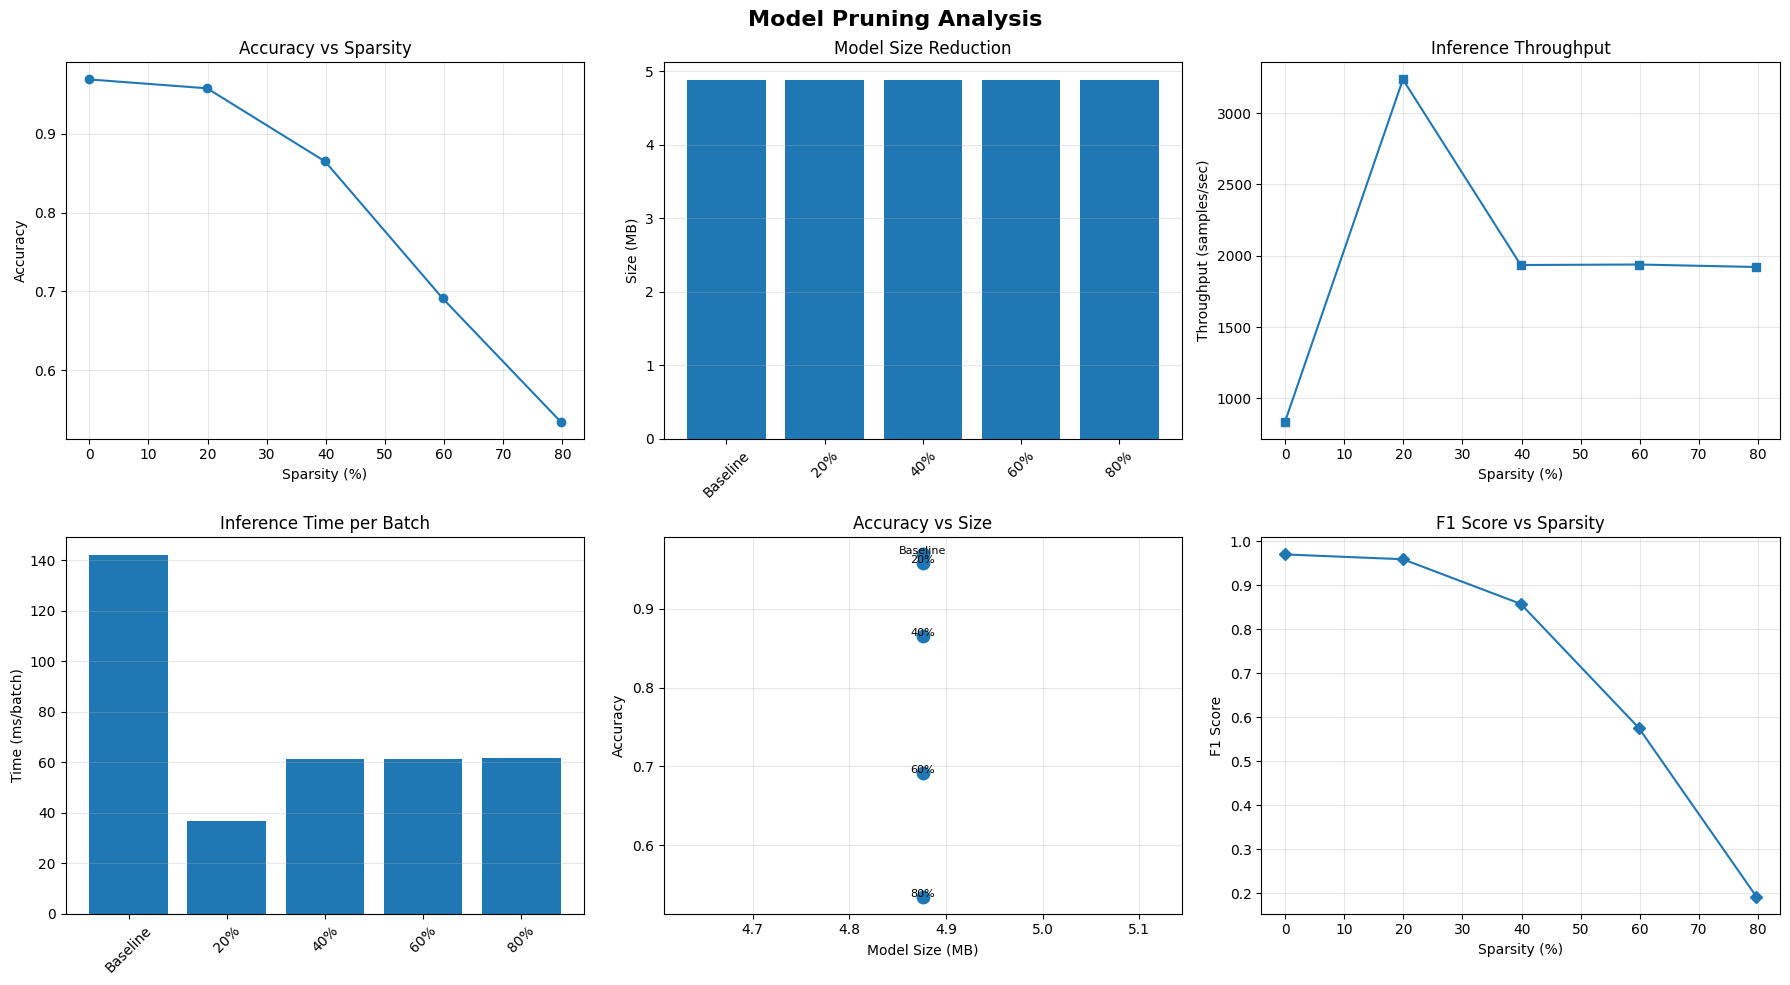

In [17]:
print("Generating visualizations...")

prune_levels = ['Baseline'] + [f'{int(p*100)}%' for p in PRUNING_AMOUNTS]
accuracies = [baseline_metrics['accuracy']] + [results[f'unstructured_{p}']['metrics']['accuracy'] for p in PRUNING_AMOUNTS]
sizes = [baseline_size['size_mb']] + [results[f'unstructured_{p}']['size']['size_mb'] for p in PRUNING_AMOUNTS]
sparsities = [baseline_sparsity] + [results[f'unstructured_{p}']['sparsity'] for p in PRUNING_AMOUNTS]
throughputs = [baseline_metrics['throughput']] + [results[f'unstructured_{p}']['metrics']['throughput'] for p in PRUNING_AMOUNTS]
inference_times = [baseline_metrics['avg_inference_time']*1000] + [results[f'unstructured_{p}']['metrics']['avg_inference_time']*1000 for p in PRUNING_AMOUNTS]
f1_scores = [baseline_metrics['f1']] + [results[f'unstructured_{p}']['metrics']['f1'] for p in PRUNING_AMOUNTS]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Pruning Analysis', fontsize=16, fontweight='bold')

axes[0, 0].plot(sparsities, accuracies, marker='o')
axes[0, 0].set_xlabel('Sparsity (%)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs Sparsity')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(range(len(sizes)), sizes)
axes[0, 1].set_xticks(range(len(prune_levels)))
axes[0, 1].set_xticklabels(prune_levels, rotation=45)
axes[0, 1].set_ylabel('Size (MB)')
axes[0, 1].set_title('Model Size Reduction')
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[0, 2].plot(sparsities, throughputs, marker='s')
axes[0, 2].set_xlabel('Sparsity (%)')
axes[0, 2].set_ylabel('Throughput (samples/sec)')
axes[0, 2].set_title('Inference Throughput')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].bar(range(len(inference_times)), inference_times)
axes[1, 0].set_xticks(range(len(prune_levels)))
axes[1, 0].set_xticklabels(prune_levels, rotation=45)
axes[1, 0].set_ylabel('Time (ms/batch)')
axes[1, 0].set_title('Inference Time per Batch')
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].scatter(sizes, accuracies, s=80)
for i, txt in enumerate(prune_levels):
    axes[1, 1].annotate(txt, (sizes[i], accuracies[i]), fontsize=8, ha='center')
axes[1, 1].set_xlabel('Model Size (MB)')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Accuracy vs Size')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(sparsities, f1_scores, marker='D')
axes[1, 2].set_xlabel('Sparsity (%)')
axes[1, 2].set_ylabel('F1 Score')
axes[1, 2].set_title('F1 Score vs Sparsity')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pruning_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved visualization to 'pruning_analysis.png'")
plt.show()

## Summary Table & Simple Recommendation

In [18]:
print("="*70)
print("SUMMARY TABLE")
print("="*70)

print("\n{:<15} {:<10} {:<10} {:<12} {:<12} {:<15}".format(
    "Config", "Acc", "SizeMB", "Sparsity(%)", "Time(ms)", "Throughput"))
print("-"*80)

prune_levels = ['Baseline'] + [f'{int(p*100)}%' for p in PRUNING_AMOUNTS]

for i, level in enumerate(prune_levels):
    key = 'baseline' if i == 0 else f'unstructured_{PRUNING_AMOUNTS[i-1]}'
    r = results[key]
    print("{:<15} {:<10.4f} {:<10.2f} {:<12.2f} {:<12.2f} {:<15.1f}".format(
        level,
        r['metrics']['accuracy'],
        r['size']['size_mb'],
        r['sparsity'],
        r['metrics']['avg_inference_time'] * 1000,
        r['metrics']['throughput']
    ))

print("\n🎯 Recommendation (heuristic):")
best_config = None
for prune_amount in PRUNING_AMOUNTS:
    key = f'unstructured_{prune_amount}'
    acc_drop = baseline_metrics['accuracy'] - results[key]['metrics']['accuracy']
    if acc_drop < 0.02:
        best_config = (prune_amount, results[key])

if best_config:
    amount, res = best_config
    print(f"  Use {amount*100:.0f}% unstructured sparsity: <2% accuracy drop,")
    print(f"  ~{(1 - res['size']['size_mb']/baseline_size['size_mb'])*100:.1f}% size reduction,")
    print(f"  throughput change: {(res['metrics']['throughput']/baseline_metrics['throughput']-1)*100:+.1f}%")
else:
    print("  All tested levels exceeded 2% accuracy drop. Try milder pruning or fine-tuning.")

print("\n(For edge-device story, consider switching to structured channel pruning next.)")

SUMMARY TABLE

Config          Acc        SizeMB     Sparsity(%)  Time(ms)     Throughput     
--------------------------------------------------------------------------------
Baseline        0.9691     4.88       0.00         141.91       836.2          
20%             0.9579     4.88       19.93        36.67        3236.5         
40%             0.8652     4.88       39.85        61.33        1934.8         
60%             0.6910     4.88       59.78        61.22        1938.3         
80%             0.5346     4.88       79.70        61.78        1920.9         

🎯 Recommendation (heuristic):
  Use 20% unstructured sparsity: <2% accuracy drop,
  ~0.0% size reduction,
  throughput change: +287.0%

(For edge-device story, consider switching to structured channel pruning next.)


In [20]:
if best_config:
    amount, res = best_config

    # Recreate the best pruned model from the original model
    best_pruned_model = apply_unstructured_pruning(original_model, amount=amount)

    pruned_filename = f"pruned_{int(amount*100)}pct.onnx"
    pruned_onnx_path, pruned_onnx_size = export_model_to_onnx(
        best_pruned_model, filename=pruned_filename
    )
    print(f"Pruned ONNX size: {pruned_onnx_size:.2f} MB "
          f"(baseline {baseline_onnx_size:.2f} MB)")
else:
    print("No pruned model within 2% accuracy drop, skipping ONNX export for pruned config.")


✅ Exported ONNX model to onnx_exports\pruned_20pct.onnx (4.88 MB)
✅ ONNX model passed checker
Pruned ONNX size: 4.88 MB (baseline 4.88 MB)
